### Disease unbalanced input data to RF (run1): analysis of classifier resutls

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_recall_curve,average_precision_score,confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# loading data: unbalanced data
X = pd.read_csv('./data/MergedData_reduced.tsv', sep='\t', index_col=0)
Y = pd.read_csv('./data/MergedLabels_reduced.tsv', sep='\t', index_col=0)

#splitting data into training and test
# data are split randomly 
# Cannot balance based on disease because disease are not balanced
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state=42, test_size=0.2)

# loading model
model = RandomForestClassifier(n_estimators=5000, max_depth=5,random_state=0, oob_score=True, n_jobs=-1, verbose=1)
# fitting model to data
model.fit(X_train, Y_train.values.ravel())
# predicting on the held out (test) set
pred = model.predict(X_test)
#scorring accuracy of model
score = (model.score(X_test, Y_test.values.ravel()))

#getting probability scores for each sample
# probability scores for both classes (RiboD, PolyA) will sum to 1
y_proba = model.predict_proba(X_test)[:,1]

# mean precision score
precision, recall, _ = precision_recall_curve(Y_test, y_proba)
mean_precision = average_precision_score(Y_test, y_proba)

pred_proba = model.predict_proba(X_test)

res = {} # results dictionary to be used later for downstream analysis

res['test_labels'] = Y_test.values.ravel()
res['pred_labels'] = pred
res['pred_proba'] = pred_proba
res['acc'] = score
res['oob_score'] = model.oob_score_
res['model'] = model
res['average_precision'] = mean_precision
res['precision'] = precision
res['recall'] = recall
res['genes'] = X.columns.tolist()
res['importances'] = model.feature_importances_
res['test_samples'] = X_test.index.values

np.save('./results/RF_results_run1.npy', res)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 170 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 420 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 770 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 1220 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 1770 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 2420 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 3170 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 4020 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 4970 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:   38.5s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=15)]: Done 170 tasks      | elapsed:    0.3s
[Parallel(n_j

In [4]:
results = np.load('./results/RF_results_run2.npy').item()

In [5]:
print('Accuracy achieved: %.3f'%results['acc'])

Accuracy achieved: 0.978


In [6]:
print('Average precision achieved: %.3f'%results['average_precision'])

Average precision achieved: 0.985


In [7]:
# Calculating Confusion Matrix
mat = confusion_matrix(results['test_labels'], results['pred_labels'])

### Confusion matrix shows perfect separation between the two calsses
* Class 0: PolyA libraries
* Class 1: Ribo-deplete libraries

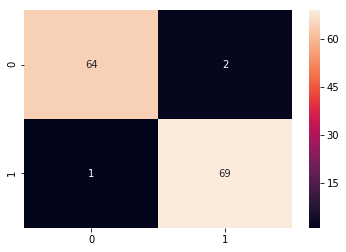

In [8]:
sns.heatmap(mat, annot=True)

In [9]:
importances = zip(results['importances'], results['genes'])

In [10]:
importances = sorted(importances, key = lambda x:x[0], reverse=True)


In [11]:
scores = list(map(lambda x:x[0], importances[:20]))
genes = list(map(lambda x:x[1], importances[:20]))

### Gene importance determined by RF classifier

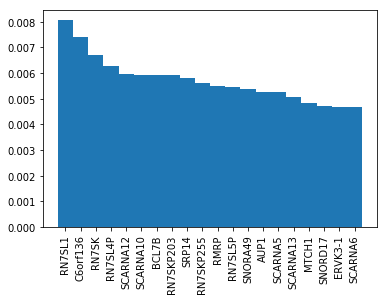

In [12]:
plt.bar(np.arange(len(scores)), scores, width=1)
plt.xticks(labels=genes, ticks=np.arange(len(scores)), rotation=90)
plt.show()
plt.close()

In [13]:
with open('/mnt/RiboVsPolyA/results/RF_gene_rank_run1.tsv', 'w') as f:
    f.write('Gene\tScore\n')
    for i in range(len(scores)):
        score = scores[i]
        gene = genes[i]
        f.write(gene+'\t'+str(score)+'\n')
        
    

#### Visualizing the effectiveness of the probability threshold
* Threshold of 0.5 seems to separate the two classes perfectly

Text(0.5, 1.0, 'Probability of being Ribo')

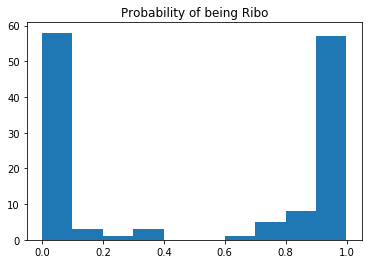

In [14]:
plt.hist(results['pred_proba'][:,1])
plt.title('Probability of being Ribo')